In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, LearnableSwitchSimple
from sparse_causal_model_learner_rl.trainable.model import ModelModel

gin.enter_interactive_mode()
from sparse_causal_model_learner_rl.loss.losses import fit_loss, manual_switch_gradient
from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices

In [2]:
gin.bind_parameter('LearnableSwitchSimple.initial_proba', 0.01)
gin.bind_parameter('LearnableSwitchSimple.sample_many', True)
gin.bind_parameter('WithInputSwitch.enable_switch', True)
gin.bind_parameter('WithInputSwitch.give_mask', True)

gin.bind_parameter('WithInputSwitch.switch_cls', LearnableSwitchSimple)

In [3]:
ishape = 10


In [4]:
class Model(nn.Module):
    def __init__(self, input_shape, **kwargs):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=2*ishape, out_features=500)
#         self.fc2 = nn.Linear(in_features=500, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=1)
    def forward(self, x, **kwargs):
#         print(x.shape)
        x = x.view(x.shape[0], 2*ishape)
        x = self.fc1(x)
        x = nn.Sigmoid()(x)
#         x = self.fc2(x)
#         x = nn.Sigmoid()(x)
        x = self.fc3(x)
        x = x.view(x.shape[0], 1, 1)
        return x
class WrapModel(nn.Module):
    
    def __init__(self, model):
        self.n_features = ishape
        self.n_actions = 0
        super(WrapModel, self).__init__()
        self.model = model
    def forward(self,  x, **kwargs):
        return self.model(x, **kwargs)

In [5]:
X = torch.randn((1000, ishape)).cuda()
y = torch.sin(2 * X[:, 0]) + torch.cos( X[:, 1]) + torch.abs(torch.nn.Tanh()(X[:, -1]))
y = y.reshape(-1, 1, 1)
X = X/3
y=y/3

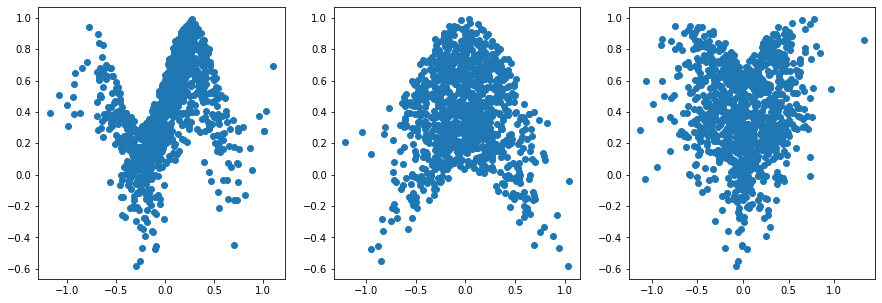

In [6]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0].cpu().numpy(), y.cpu().flatten().numpy())
plt.subplot(1, 3, 2)
plt.scatter(X[:, 1].cpu().numpy(), y.cpu().flatten().numpy())
plt.subplot(1, 3, 3)
plt.scatter(X[:, -1].cpu().numpy(), y.cpu().flatten().numpy())

In [7]:
y.shape

torch.Size([1000, 1, 1])

In [8]:
wsw = WrapModel(WithInputSwitch(model_cls=Model, n_models=1, input_shape=(ishape,))).cuda()

In [9]:
wsw(X).shape, y.shape

(torch.Size([1000, 1, 1]), torch.Size([1000, 1, 1]))

In [10]:
opt = torch.optim.Adam(lr=1e-3, params=wsw.parameters())

In [11]:
losses = []
losses_switch = []
losses_noswitch = []
coeffs = []
coeff = 0.01


In [21]:
for i in tqdm(range(10000)):
    opt.zero_grad()
    loss_noswitch = (wsw(X, enable_switch=False) - y).pow(2).mean()
    loss_switch = (wsw(X) - y).pow(2).mean()
    delta = loss_switch / loss_noswitch
    loss = loss_switch + loss_noswitch
    loss_nozero = torch.nn.ReLU()(0.5 - wsw.model.switch.probas).sum()
    
#     if i % 10 == 0:
#         if delta.item() > 2:
#             coeff *= 0.5
#         else:
#             coeff /= 0.5
#         if coeff > 10:
#             coeff = 10
#         if coeff < 1e-5:
#             coeff = 1e-5
    
    
    loss_sparse = wsw.model.switch.probas.abs().sum()
    loss += loss_nozero + loss_sparse * coeff
    manual_switch_gradient(wsw(X), y, wsw)
    loss.backward(retain_graph=True)
    opt.step()
    losses.append(loss.item())
    losses_switch.append(loss_switch.item())
    losses_noswitch.append(loss_noswitch.item())
    coeffs.append(coeff)

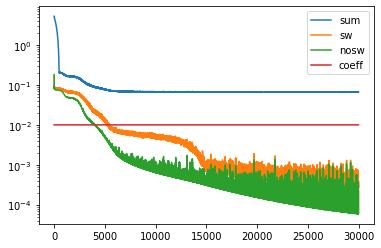

In [22]:
plt.plot(losses, label='sum')
plt.plot(losses_switch, label='sw')
plt.plot(losses_noswitch, label='nosw')
plt.plot(coeffs, label='coeff')
plt.yscale('log')
plt.legend()

<AxesSubplot:>

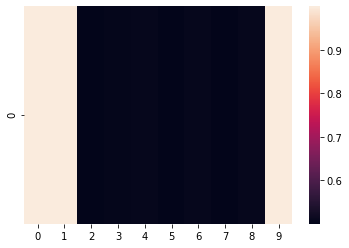

In [23]:
sns.heatmap(wsw.model.switch.probas.cpu().detach().reshape(1, ishape))

In [24]:
wsw.model.switch.probas

Parameter containing:
tensor([[0.9998],
        [0.9995],
        [0.5016],
        [0.5050],
        [0.5064],
        [0.5022],
        [0.5065],
        [0.5004],
        [0.5064],
        [0.9979]], device='cuda:0', requires_grad=True)